In [155]:
%matplotlib inline
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
from scipy import signal
import peakutils
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import kmeans2,vq, whiten
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from hmmlearn.hmm import MultinomialHMM
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def transform_to_str(pred):
    s = ''
    for i in pred:
        if i == 26:
            s += ' '
        else:
            s += chr(97 + i)
    return s

In [157]:
(rate,sig) = wav.read("alice_slow.wav")
sig = sig[:, 0]
mfcc_feat = mfcc(sig, rate)
mfcc_feat.shape

(60696, 13)

In [158]:
f, t, Sxx = signal.spectrogram(sig, rate)
# t -> X, time
# f -> Y, frequency in HZ
# Sxx -> C, actual values themselves

In [177]:
s = "alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversations so she was considering in her own mind as well as she could for the day made her feel very sleepy and stupid whether the pleasure of making a daisy chain would be worth the trouble of getting up and picking the daisies when suddenly a white abbit with pink eyes ran close by her there was nothing so very remarkable in that nor did alice think it so very much out of the way to hear the rabbit say to itself oh dear oh dear i shall be too late but when the rabbit actually took a watch out of its waistcoat pocket and looked at it and then hurried on alice started to her feet for it flashed across her mind that she had never before seen a rabbit with either a waistcoat pocket or watch to take out of it and burning wit curiosity she ran acrross the field after it and was just in time to see it pop down a large rabbit hole under the hedge in another moment down went alice after it the rabbit hole went straight on like a tunnel for some way and then dipped sudddenly down so suddenly that alice had not a moment to think about stopping herself before she found herself falling down what seemed to be a very deep well either the well was very deep or she fell very slowly for she had plenty of time as she went down to look about her first she tried to make out what she was coming to but it was too dark to see anything then she looked at the sides of the wall and noticed that they were filled with cupboards and book shelves here and there she saw maps and pictures hung upon pegs she took down a jar from one of the shelves she passed it was labeled orange marmalade but to her great disappointment it was empty she did not like to drop the jar so managed to put it into one of the cupboardsa as she fell past it down down down would the fall never come to an end there was nothing ele to do"
sig_str = np.sum(Sxx[3:70, :], axis=0)
# According to paper, usually around 100ms left between 
# conseuctive keystrokes so min_dist should be around 20
# Difference between adjacent signals is 0.005ms
indexes = peakutils.indexes(sig_str, thres=0.008, min_dist=18)
print indexes
len(indexes), len(s)

[   586    606    639 ..., 119013 119037 119068]


(2112, 2092)

(0, 10)

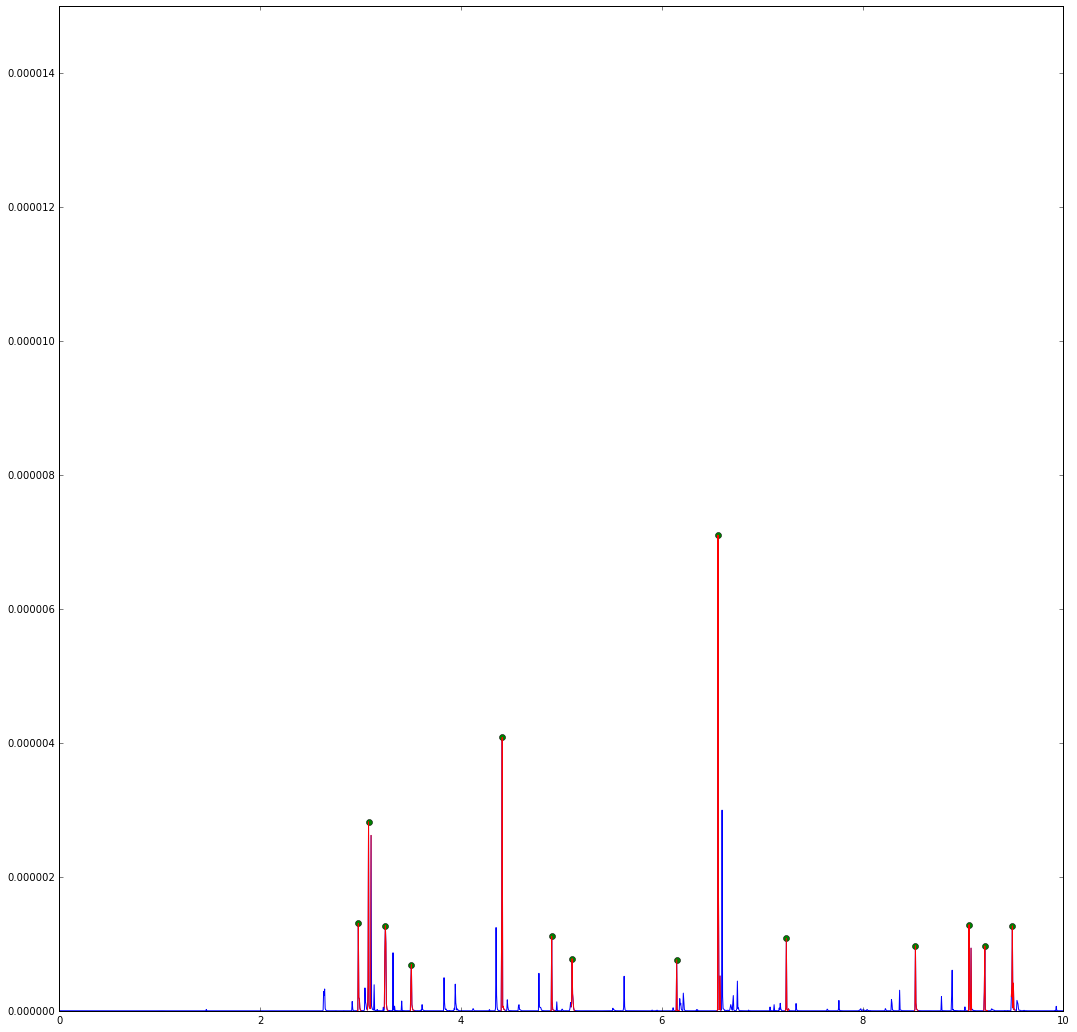

In [178]:
fig = plt.figure(figsize=(18, 18))
plt.plot(t, sig_str)
plt.plot(t[indexes], sig_str[indexes], 'o')

keystroke_feats = []
wave_len = 0.04
for i in range(len(indexes)):
    ind = indexes[i]
    plt.plot(t[ind - 2: ind + 6], sig_str[ind - 2: ind + 6], 'r')
    # Take exactly 40 ms
    key_start = int(t[ind - 2] * rate)
    key_end = int(key_start + wave_len * rate)
    keypress_sig = sig[key_start:key_end]
    mfcc_feat = mfcc(keypress_sig, rate, winlen=0.01, 
    winstep=0.0025, numcep=16, nfilt=32, 
    lowfreq=400, highfreq=12000)
    keystroke_feats.append(np.concatenate(mfcc_feat[2:7, :]).T)
data = np.vstack(keystroke_feats)
data.shape
plt.ylim(0, 1.5e-5)
plt.xlim(0, 10)

In [214]:
# Maybe just do some parameter tuning, try to maximize number of unique words found in set
# Find and extract all parameters that can be taken out
# Try to use dataframes

keystroke_feats = []
wave_len = 0.04
for i in range(len(indexes)):
    ind = indexes[i]
    # Take exactly 40 ms
    key_start = int(t[ind - 2] * rate)
    key_end = int(key_start + wave_len * rate)
    keypress_sig = sig[key_start:key_end]
    mfcc_feat = mfcc(keypress_sig, rate, winlen=0.01, 
    winstep=0.0025, numcep=16, nfilt=32, 
    lowfreq=400, highfreq=12000)
    keystroke_feats.append(np.concatenate(mfcc_feat[2:9, :]).T)
data = np.vstack(keystroke_feats)
data.shape

data_w = whiten(data)
kmeans = KMeans(n_clusters=50).fit(data_w)

labels = kmeans.labels_.reshape(-1, 1)

# Init spaces to reasonable values
space_inds = [i for i, letter in enumerate(s) if letter == " "][:20]
spaces = kmeans.labels_[space_inds]

# Build transition matrix
trans_m = np.zeros((27, 27)) + 1
for i in range(len(s)-1):
    c, next_c = ord(s[i]) - 97, ord(s[i+1]) - 97
    if c < 0:
        c = 26
    if next_c < 0:
        next_c = 26
    trans_m[c][next_c] += 1

# 50 by 27 symbols, emission matrix, random init for all but 27 (space)
emiss_m = np.random.rand(27, hmm.n_features)
space_vec = np.zeros((50)) + 5
for i in spaces:
    space_vec[i] += 1
emiss_m[26, :] = space_vec

row_sums = trans_m.sum(axis=1)
trans_m = trans_m / row_sums[:, np.newaxis]

row_sums = emiss_m.sum(axis=1)
emiss_m = emiss_m / row_sums[:, np.newaxis]

hmm = MultinomialHMM(n_components=27, verbose=True, init_params="e", params="se", tol=1e-4, n_iter=5000) 
hmm.n_features = 50

hmm.transmat_ = trans_m
hmm.emissionprob_ = emiss_m

hmm = hmm.fit(labels)
logprob, pred = hmm.decode(labels, algorithm='viterbi')

         1       -8311.6753             +nan
         2       -8172.6618        +139.0136
         3       -8169.3634          +3.2984
         4       -8165.9528          +3.4106
         5       -8162.2596          +3.6931
         6       -8158.1384          +4.1213
         7       -8153.4437          +4.6947
         8       -8148.0481          +5.3955
         9       -8141.8617          +6.1865
        10       -8134.8503          +7.0114
        11       -8127.0498          +7.8005
        12       -8118.5670          +8.4827
        13       -8109.5675          +8.9995
        14       -8100.2520          +9.3155
        15       -8090.8279          +9.4240
        16       -8081.4820          +9.3459
        17       -8072.3605          +9.1216
        18       -8063.5612          +8.7993
        19       -8055.1378          +8.4234
        20       -8047.1107          +8.0271
        21       -8039.4809          +7.6298
        22       -8032.2428          +7.2381
        23

In [215]:
# Look at why scale is completely different between mike and mines
# Look at how Mike does things differently from you in general
# Experiment with     windows
# Experiment with a more representative transition matrix
# Try experimenting with how far back you fall from the window

In [216]:
print np.exp(logprob/(len(pred)))
print transform_to_str(pred)

0.0165878575581
s a abupoupar whourt s in ingqzbllite bllit hithe worsas llithelllfoubuars ishe her bo souppofans bbico sild de winkwally d wi abupiepppithok the s mind wad ike at wor wit angher cenke ather habbedersur wnghe ay mepkxjjun iche heralit t thabfoke sher wabo adseryjqjpinshery whily cedar her ise al bursice owhingershan t we abver he t adoputhe sel ichithe n all f my tomen s he toopficound oud bof thinge wng me hat ser hever toura alk ait the tor se all herykiting ad tud wok s asokemas o t as nghthasok s he fat he t s bra foff bud she t wicothined ingoks ton d wondondsith cor hesaslind ve soungande s toratuce wall t in t ing ithaberngher than wher thory menve outhelin sak the ant out he ice n me of hitithakashe nd t mite heal in sjusicut poshe ly wars cxy o athery wathad wankerandoof omey f t tungby wondson shether okit se of t ak wqzqy comery wingy theryjxofangass al heryong f theal omik t de tof the sicedovzjqckit ithare the wngice s o wn aborale bokjxjqshever ting thers 

In [210]:
0.001 - 1e-4

0.0009